In [1]:
import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.feature_extraction.text
import sklearn.multiclass
import sklearn.linear_model
% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [2]:
df = ld.load_data()

C:\Users\kevin.rose\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2881: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
crime_df = df.ix[df['relevant'], :]
print(crime_df.shape)
crime_df = crime_df.ix[crime_df.loc[:, 'OEMC':'TASR'].any(1), :]
print(crime_df.shape)

idx = np.random.permutation(crime_df.shape[0])
trn = crime_df.iloc[idx[:int(crime_df.shape[0] * 0.7)], :]
tst = crime_df.iloc[idx[int(crime_df.shape[0] * 0.7):], :]
print(trn.shape)
print(tst.shape)

(112091, 45)
(34253, 45)
(23977, 45)
(10276, 45)


In [4]:
# vectorize data
vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=1)
X = vectorizer.fit_transform(trn['bodytext'].values)

tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer(use_idf=True,
                                                                    smooth_idf=True)
X = tfidf_transformer.fit_transform(X)

Y = trn.loc[:, 'OEMC':'TASR'].values

In [5]:
X.shape

(23977, 118873)

In [6]:
clf = sklearn.multiclass.OneVsRestClassifier(
    sklearn.linear_model.LogisticRegression()
)
clf.fit(X, Y)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [7]:
X_tst = tfidf_transformer.transform(vectorizer.transform(tst['bodytext'].values))
Y_tst = tst.loc[:, 'OEMC':'TASR'].values

Y_hat = clf.predict_proba(X_tst)

In [8]:
perf = pd.DataFrame()

for i in range(Y_hat.shape[1]):
    tag = tst.columns[7+i]
    perf.loc['TP', tag] = sum((Y_hat[:,i] > .5) & (Y_tst[:,i] == 1))
    perf.loc['FP', tag] = sum((Y_hat[:,i] > .5) & (Y_tst[:,i] == 0))
    perf.loc['TN', tag] = sum((Y_hat[:,i] < .5) & (Y_tst[:,i] == 0))
    perf.loc['FN', tag] = sum((Y_hat[:,i] < .5) & (Y_tst[:,i] == 1))
    perf.loc['TPR', tag] = perf.loc['TP', tag] / (perf.loc['TP', tag] + perf.loc['FN', tag])
    perf.loc['FPR', tag] = perf.loc['FP', tag] / (perf.loc['FP', tag] + perf.loc['TN', tag])
    perf.loc['PPV', tag] = perf.loc['TP', tag] / (perf.loc['TP', tag] + perf.loc['FP', tag])

perf = perf.T
perf

,TP,FP,TN,FN,TPR,FPR,PPV
OEMC,0.0,0.0,10231.0,45.0,0.000000,0.000000,NaN
CPD,4505.0,1029.0,3934.0,808.0,0.847920,0.207334,0.814059
SAO,332.0,82.0,9199.0,663.0,0.333668,0.008835,0.801932
CCCC,95.0,31.0,9505.0,645.0,0.128378,0.003251,0.753968
CCJ,57.0,8.0,9992.0,219.0,0.206522,0.000800,0.876923
CCSP,146.0,24.0,9851.0,255.0,0.364090,0.002430,0.858824
CPUB,0.0,0.0,10212.0,64.0,0.000000,0.000000,NaN
IDOC,1.0,0.0,10189.0,86.0,0.011494,0.000000,1.000000
DOMV,143.0,26.0,9741.0,366.0,0.280943,0.002662,0.846154
SEXA,484.0,29.0,9506.0,257.0,0.653171,0.003041,0.943470


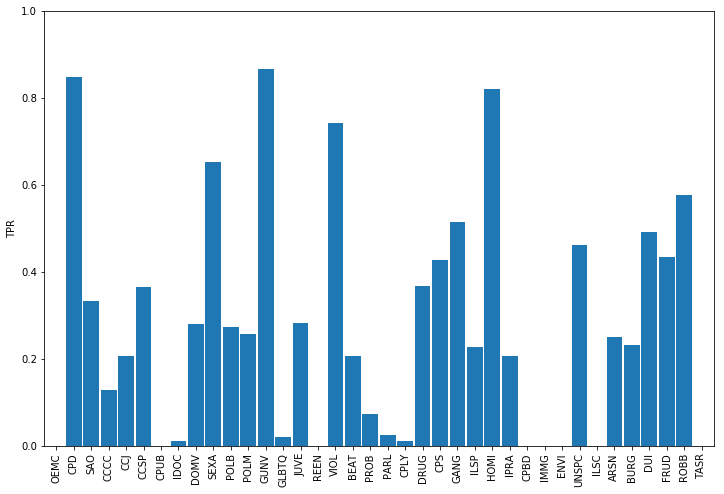

In [9]:
perf['TPR'].plot(kind='bar', ylim=[0,1], width=.9)
plt.ylabel('TPR');

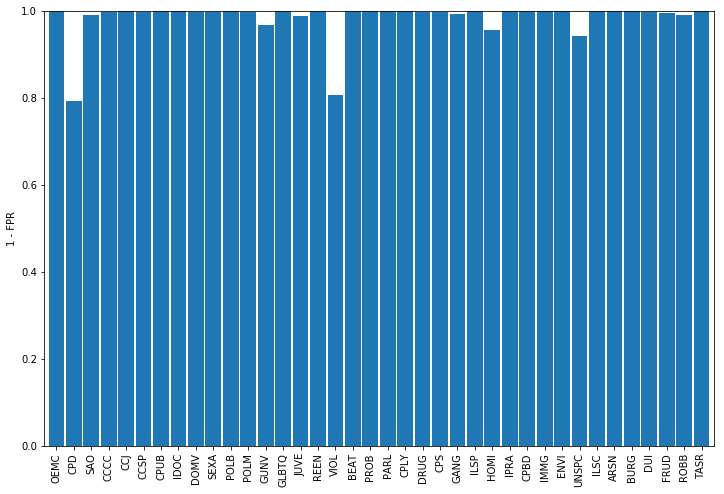

In [10]:
(1 - perf['FPR']).plot(kind='bar', ylim=[0,1], width=.9)
plt.ylabel('1 - FPR');

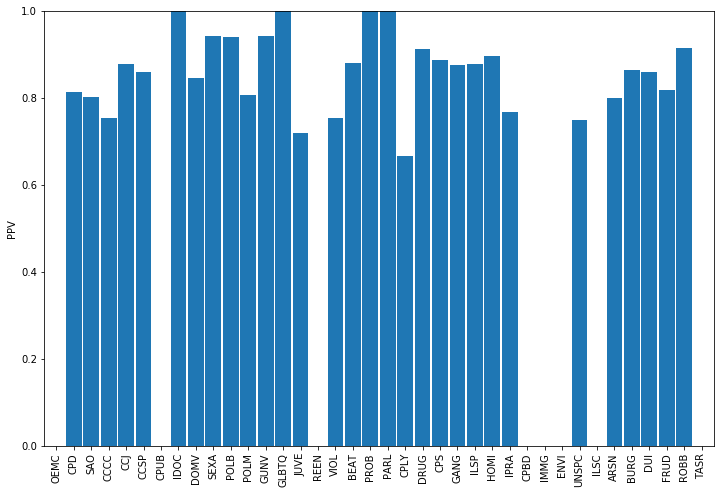

In [11]:
perf['PPV'].plot(kind='bar', ylim=[0,1], width=.9)
plt.ylabel('PPV');

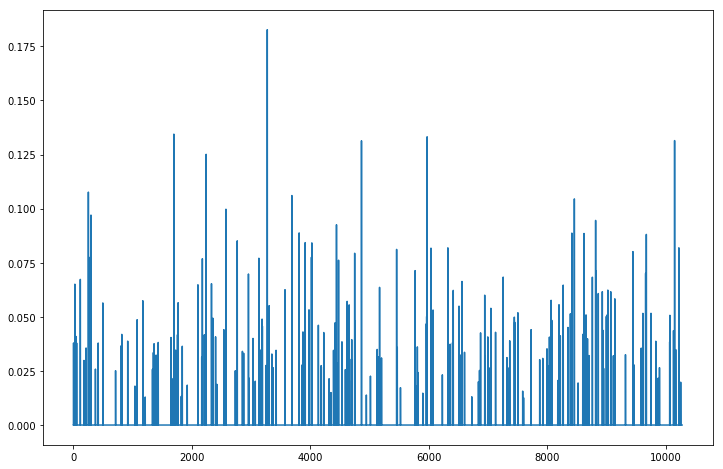

In [12]:
plt.plot(X_tst[:, 0].todense())

In [13]:
import benchmark_tagging as bt

In [14]:
print(bt.benchmark(
    lambda: sklearn.multiclass.OneVsRestClassifier(
        sklearn.linear_model.LogisticRegression()
    ),
    tfidf_transformer.transform(vectorizer.transform(crime_df['bodytext'].values)),
    crime_df.loc[:, 'OEMC':'TASR'].values
))

[0.96019444922441555, 0.96012219032926238, 0.95974726024450363, 0.96029428938456152]


In [15]:
from importlib import reload

In [16]:
reload(bt)

<module 'benchmark_tagging' from 'C:\\Users\\kevin.rose\\Documents\\GitHub\\cjp-article-tagging\\src\\benchmark_tagging.py'>

In [17]:
print(np.mean([0.96019444922441555, 0.96012219032926238, 0.95974726024450363, 0.96029428938456152]))

0.960089547296
